# Graph Statistics

In [181]:
from c_elegans.witvilet2020.load_wit import load_wit
from c_elegans.worm_wiring.load_worm import load_worm
import os
from graph import GraphIO
import networkx as nx
from networkx.algorithms.components import number_strongly_connected_components as ncc_strong
from networkx.algorithms.components import number_weakly_connected_components as ncc_weak
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d.axes3d import Axes3D as a3d
import seaborn as sns
import numpy as np

In this notebook, I will show how to obtain basic graph statistics (number of nodes, density, etc.) from the graphs stored in our filespec.

## Load the Graphs

In [17]:
worm_graphs = load_worm()
wit_graphs = load_wit()
worm_connectomes = worm_graphs[-6:]
worm_contactomes = worm_graphs[:2]
worm_cellclass_omes = worm_graphs[2:8]
worm_synadj = worm_graphs[8:-6]

script_dir = os.getcwd()
base_path = os.path.join(script_dir, "json_connectomes")
ciona_path = os.path.join(base_path, "ciona.json")
fafb_path = os.path.join(base_path, "fafb.json")
neuPrint_path = os.path.join(base_path, "neuPrint_graphs.json")
ciona_graph, _, _, _ = GraphIO.load(ciona_path)
fafb_graph, _, _, _ = GraphIO.load(fafb_path)
neuPrint_graph, _, _, _ = GraphIO.load(neuPrint_path)

## Obtain Graph Statistics and Metadata

In [147]:
lcc_size = [] #Instead of number of nodes -- number of nodes in largest weakly connected component
density = []
num_strong = []
num_weak = []
in_degree = []
out_degree = []
synapse_type = []
sex = []
graph_origin = []

for g in worm_connectomes:
    graph_origin.append("worm")
    lcc_size.append(len(max(nx.weakly_connected_components(g))))
    density.append(nx.density(g))
    num_strong.append(ncc_strong(g))
    num_weak.append(ncc_weak(g))
    in_degree.append([d for n, d in g.in_degree()])
    out_degree.append([d for n, d in g.out_degree()])
    synapse_type.append(g.graph['Synapse Type'])
    sex.append(g.graph['Sex'])
    
for graph in wit_graphs:
    chemical_edges = []
    electrical_edges = []
    for *edge, attr in graph.edges(data=True, keys=True):
        if attr['synapse_type'] == "chemical":
            chemical_edges.append((*edge,))
        elif attr['synapse_type'] == "electrical":
            electrical_edges.append((*edge,))
    g_chemical = graph.edge_subgraph(chemical_edges)
    g_electrical = graph.edge_subgraph(electrical_edges)
    for g, syn_type in [(g_chemical, "Chemical"), (g_electrical, "Total Gap Junction")]:
        graph_origin.append("wit")
        lcc_size.append(len(max(nx.weakly_connected_components(g))))
        density.append(nx.density(g))
        num_strong.append(ncc_strong(g))
        num_weak.append(ncc_weak(g))
        in_degree.append([d for n, d in g.in_degree()])
        out_degree.append([d for n, d in g.out_degree()])
        synapse_type.append(syn_type)
        sex.append(g.graph['Sex'])
        
for g, origin in zip([fafb_graph, neuPrint_graph], ["fafb", "NeuPrint"]):
    graph_origin.append(origin)
    lcc_size.append(len(max(nx.weakly_connected_components(g))))
    density.append(nx.density(g))
    num_strong.append(ncc_strong(g))
    num_weak.append(ncc_weak(g))
    in_degree.append([d for n, d in g.in_degree()])
    out_degree.append([d for n, d in g.out_degree()])
    synapse_type.append("Unknown")
    sex.append("Unknown")

graph_origin.append("ciona")
lcc_size.append(len(max(nx.connected_components(ciona_graph))))
density.append(nx.density(ciona_graph))
num_strong.append(nx.number_connected_components(ciona_graph))
num_weak.append(nx.number_connected_components(ciona_graph))
in_degree.append([d for n, d in g.degree()])
out_degree.append([d for n, d in g.degree()])
synapse_type.append("Unknown")
sex.append("Unknown")

sex = np.array(sex)
lcc_size = np.array(lcc_size)
density = np.array(density)
num_strong = np.array(num_strong)
num_weak = np.array(num_weak)
in_degree = np.array(in_degree)
max_in_degree = np.array([max(in_degree[i]) for i in range(len(in_degree))])
out_degree = np.array(out_degree)
max_out_degree = np.array([max(out_degree[i]) for i in range(len(out_degree))])
graph_origin = np.array(graph_origin)
synapse_type = np.array(synapse_type)

## Visualize 

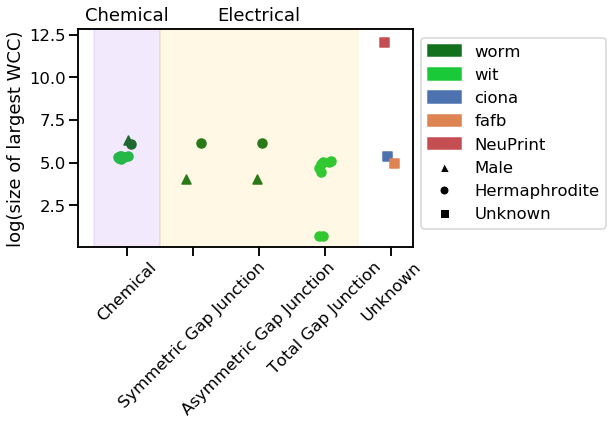

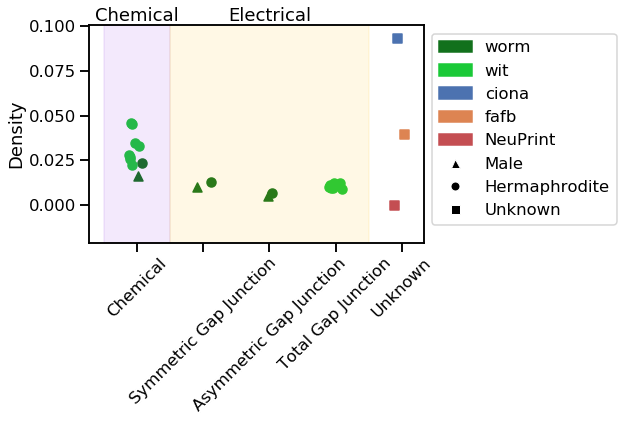

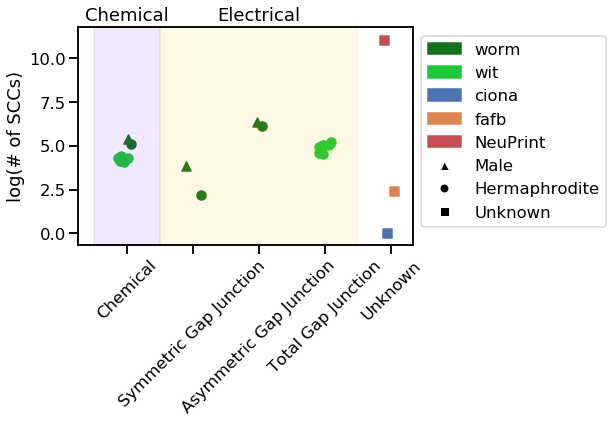

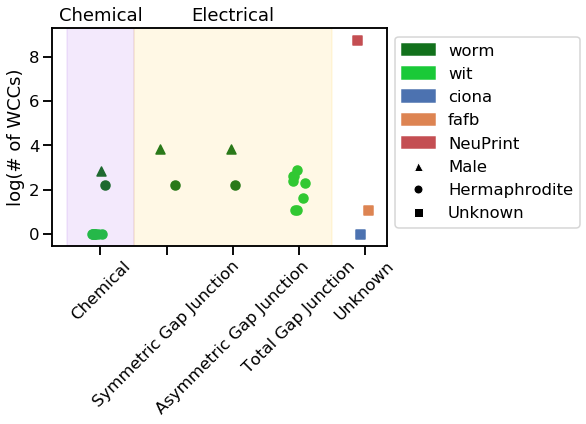

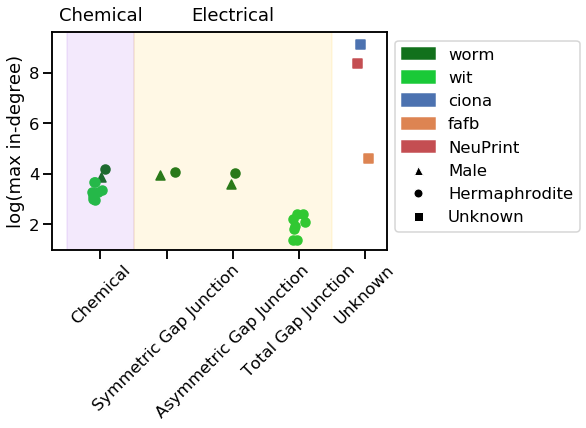

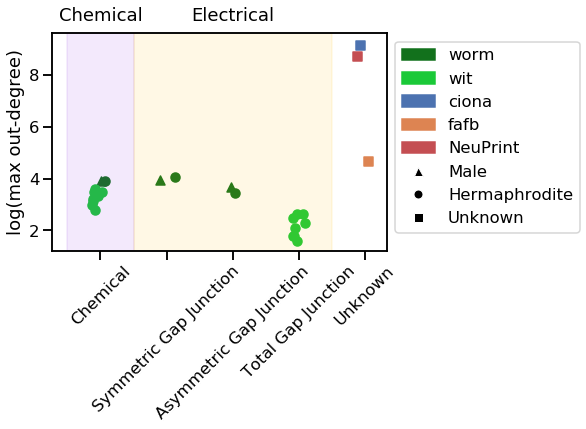

In [128]:
syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction", "Total Gap Junction", "Unknown"]
graph_origins = ["worm", "wit", "ciona", "fafb", "NeuPrint"]
syntype_pos = [float(i) for i, _ in enumerate(syntypes)]
syntype2pos = {syntype:i for i, syntype in zip(syntype_pos, syntypes)}
syn_pos = np.array([syntype2pos[syntype] for syntype in synapse_type])
syn_pos += 0.25*(np.random.rand(syn_pos.shape[0]) - 0.5) #adding jitter
sexes = ["Male", "Hermaphrodite", "Unknown"]
sex2shape = {"Male":"^", "Hermaphrodite":"o", "Unknown":"s"}
graph2color = {"ciona":palette[0], "fafb":palette[1], "worm":dark_palette[2], "wit":bright_palette[2], "NeuPrint":palette[3]}
graph2patch = {}
for g_origin in graph_origins:
    graph2patch[g_origin] = ptch.Patch(color=graph2color[g_origin], label=g_origin)
sex2patch = {}
for isex in sexes:
    sex2patch[isex] = Line2D([0], [0], marker=sex2shape[isex], color="w", markerfacecolor="k", label=isex)

def vis_stat(stat, stat_name):
    fig_max = np.max(stat)
    sns.set_context('talk')
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for isex in sexes:
        for g_origin in graph_origins:
            mask = np.logical_and(sex==isex, graph_origin==g_origin)
            plt.scatter(syn_pos[mask],
                        stat[mask],
                        c=np.array([graph2color[g_origin]]),
                        label=g_origin,
                        marker=sex2shape[isex])
    plt.text(syntype_pos[0], 1.1*fig_max, "Chemical", ha="center")
    plt.text(syntype_pos[2], 1.1*fig_max, "Electrical", ha="center")
    plt.hold=False
    plt.ylabel(stat_name)
    ax.xaxis.set_ticks(syntype_pos)
    ax.xaxis.set_ticklabels(syntypes, rotation=45)
    fill_width = 1
    ax.axvspan(syntype_pos[0]-fill_width/2, syntype_pos[0]+fill_width/2, color=bright_palette[4], alpha=0.1)
    ax.axvspan(syntype_pos[1]-fill_width/2, syntype_pos[3]+fill_width/2, color=bright_palette[8], alpha=0.1)
    handles = [graph2patch[g_origin] for g_origin in graph_origins]+[sex2patch[isex] for isex in sexes]
    plt.legend(handles=handles, bbox_to_anchor=(1,1))
    return fig
    
vis_stat(np.log(lcc_size), "log(size of largest WCC)")
vis_stat(density, "Density")
vis_stat(np.log(num_strong), "log(# of SCCs)")
vis_stat(np.log(num_weak), "log(# of WCCs)")
vis_stat(np.log(max_in_degree), "log(max in-degree)")
_ = vis_stat(np.log(max_out_degree), "log(max out-degree)")

## Visualize Degree Distributions

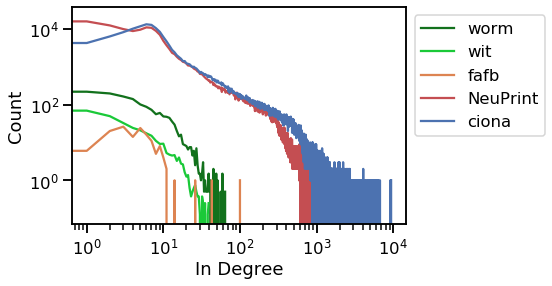

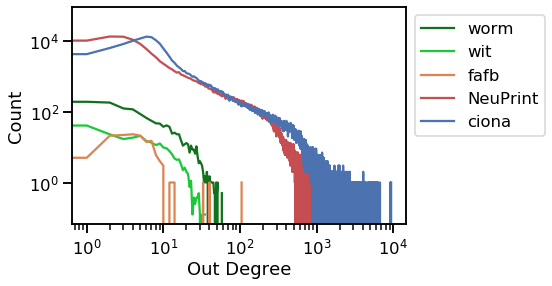

In [169]:
def vis_degree_dist(dd, graph_origin, sex, dd_name):
    dd_plot = []
    dd_labels = []
    
    #Aggregating worm_wiring and witvilet graphs
    worm = sum(dd[graph_origin=="worm"], [])
    worm_dd, _ = np.histogram(worm, bins=max(worm))
    worm_dd = worm_dd/2 #average over sex
    dd_plot.append(worm_dd)
    dd_labels.append("worm")
    wit = sum(dd[graph_origin=="wit"], [])
    wit_dd, _ = np.histogram(wit, bins=max(wit))
    wit_dd = wit_dd / len(wit_graphs) #average over age
    dd_plot.append(wit_dd)
    dd_labels.append("wit")
    
    for i, ddi in enumerate(dd):
        if graph_origin[i] != "wit" and graph_origin[i]!="worm":
            hist, _ = np.histogram(ddi, bins=max(ddi))
            dd_plot.append(hist)
            dd_labels.append(graph_origin[i])
    #plot
    fig = plt.figure()
    plt.hold = True
    for ddi, dd_label in zip(dd_plot, dd_labels):
        plt.loglog(ddi, color=graph2color[dd_label], label=dd_label)
    plt.hold = False
    plt.xlabel(dd_name)
    plt.ylabel("Count")
    plt.legend(bbox_to_anchor=(1, 1))
    return fig

vis_degree_dist(in_degree, graph_origin, sex, "In Degree")
_ = vis_degree_dist(out_degree, graph_origin, sex, "Out Degree")

# Witvilet-specific graphs

In [171]:
ages = []
microscopy_method = []
for g in wit_graphs:
    ages.append(g.graph['age'])
ages = np.array(ages)

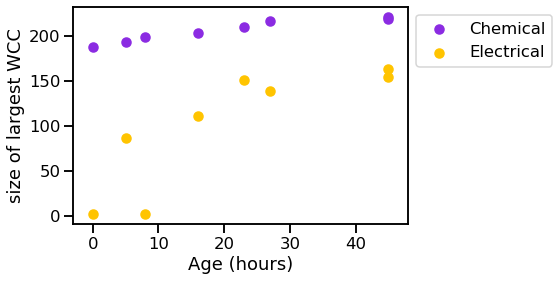

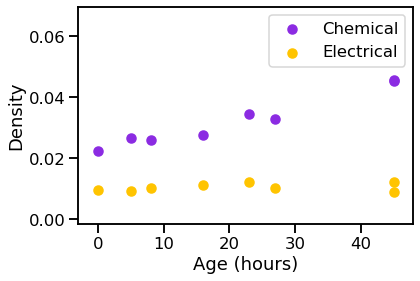

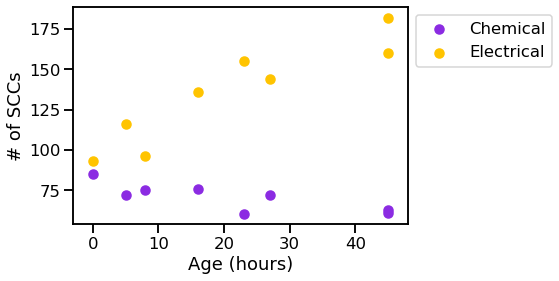

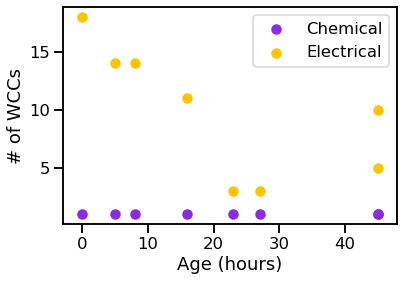

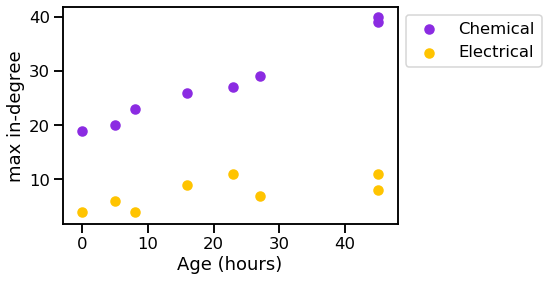

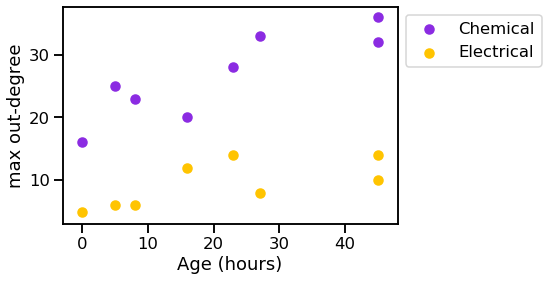

In [119]:
syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction", "Total Gap Junction"]
syntype2color = {"Chemical":bright_palette[4], "Total Gap Junction":bright_palette[8]}
def vis_stat(stat, stat_name):
    fig_max = np.max(stat)
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for syntype, synlabel in zip(["Chemical", "Total Gap Junction"], ["Chemical", "Electrical"]):
        plt.scatter(ages,
                    stat[np.logical_and(synapse_type==syntype, graph_origin=="wit")],
                    c=np.array([syntype2color[syntype]]),
                    label=synlabel)
    plt.hold=False
    plt.xlabel("Age (hours)")
    plt.ylabel(stat_name)
    plt.legend(bbox_to_anchor=(1,1))
    return fig
    
vis_stat(lcc_size,  "size of largest WCC")
vis_stat(density, "Density")
vis_stat(num_strong, "# of SCCs")
vis_stat(num_weak, "# of WCCs")
vis_stat(max_in_degree, "max in-degree")
_ = vis_stat(max_out_degree, "max out-degree")

## Degree Distributions

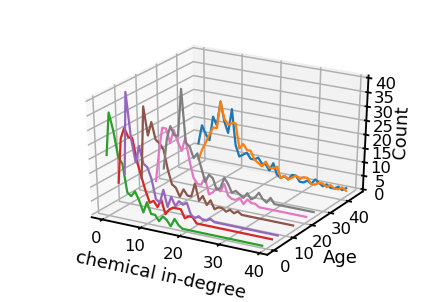

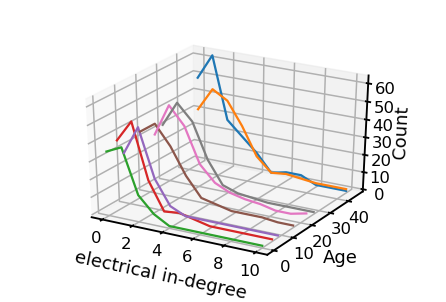

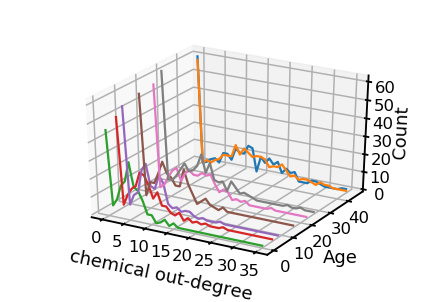

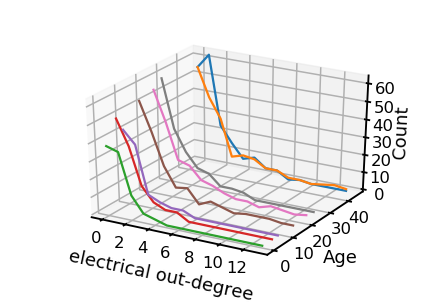

In [229]:
def vis_degree_dist(dd, max_degree, ages, dd_name):
    max_max_degree = max(max_degree)
    dd_x = np.array(range(max_max_degree))
    dd_y = ages
    dd_z = []
    for ddi in dd:
        hist, _ = np.histogram(ddi, bins=max(ddi))
        hist = np.pad(hist, (0, max_max_degree-max(ddi)))
        dd_z.append(hist)
    dd_z = np.transpose(np.array(dd_z))
    
    fig = plt.figure()
    plt.hold = True
    ax = a3d(fig)
    for i, age in enumerate(ages):
        ax.plot(dd_x, [age]*len(dd_x), dd_z[:, i])
    ax.set_xlabel("\n"+dd_name, linespacing=2)
    ax.set_ylabel("\n"+"Age", linespacing=2)
    ax.set_zlabel("Count")
    ax.dist = 12
    plt.hold = False
    return fig

chem_ins = in_degree[np.logical_and(graph_origin=="wit", synapse_type=="Chemical")]
chem_in_maxes = max_in_degree[np.logical_and(graph_origin=="wit", synapse_type=="Chemical")]
vis_degree_dist(chem_ins, chem_in_maxes, ages, "chemical in-degree")

elec_ins = in_degree[np.logical_and(graph_origin=="wit", synapse_type=="Total Gap Junction")]
elec_in_maxes = max_in_degree[np.logical_and(graph_origin=="wit", synapse_type=="Total Gap Junction")]
vis_degree_dist(elec_ins, elec_in_maxes, ages, "electrical in-degree")

chem_outs = out_degree[np.logical_and(graph_origin=="wit", synapse_type=="Chemical")]
chem_out_maxes = max_out_degree[np.logical_and(graph_origin=="wit", synapse_type=="Chemical")]
vis_degree_dist(chem_outs, chem_out_maxes, ages, "chemical out-degree")

elec_outs = out_degree[np.logical_and(graph_origin=="wit", synapse_type=="Total Gap Junction")]
elec_out_maxes = max_out_degree[np.logical_and(graph_origin=="wit", synapse_type=="Total Gap Junction")]
_ = vis_degree_dist(elec_outs, elec_out_maxes, ages, "electrical out-degree")